In [199]:
import math
import numpy as np
import pandas as pd
from pprint import pprint
import pymongo

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Mongo client
client = pymongo.MongoClient("mongodb://localhost:27017")

In [3]:
# creating a "terrorism" database 
db = client["terrorism"]

In [4]:
client.list_database_names()

['MovieLens', 'admin', 'config', 'local', 'practice', 'student', 'terrorism']

In [5]:
# collection: in terrorism database
collection = db["incidents"]

#### location object $\rightarrow$ GeoObject 
location: {

      type: "Point",
      
      coordinates: [longitude, latitude]
}

In [6]:
# collections in the database
db.list_collection_names()

['incidents']

In [7]:
# creating index: 2dsphere (for location data)
db.incidents.create_index([("location", pymongo.GEOSPHERE)])

'location_2dsphere'

In [8]:
pymongo.GEOSPHERE

'2dsphere'

In [49]:
cursor = db.incidents.aggregate([
           {
             '$geoNear': {
                           'near': {'type': "Point", 'coordinates': [ 73.99279 , 40.719296 ]},
                           'spherical': True,
                           'distanceField': "dist.calculated",
                           'num': 5
                         }
           }, {

             '$project': {'_id': 0, 'Date':  ["$iyear", "$imonth", "$iday"], 'location': 1, 'country_txt': 1, 'gname': 1}
           }
        ]);

In [50]:
# printing the events
for event in cursor:
    print(event)

{'country_txt': 'Kyrgyzstan', 'gname': 'Unknown', 'location': {'type': 'Point', 'coordinates': [72.981488, 40.933154]}, 'Date': [2017, 5, 15]}
{'country_txt': 'China', 'gname': 'Turkestan Islamic Party', 'location': {'type': 'Point', 'coordinates': [75.94243, 39.51953]}, 'Date': [2014, 7, 28]}
{'country_txt': 'China', 'gname': 'Uighur Separatists', 'location': {'type': 'Point', 'coordinates': [75.989761, 39.470107]}, 'Date': [2015, 3, 12]}
{'country_txt': 'China', 'gname': 'Uighur Separatists', 'location': {'type': 'Point', 'coordinates': [75.990067, 39.469409]}, 'Date': [2014, 7, 30]}
{'country_txt': 'China', 'gname': 'Uighur Separatists', 'location': {'type': 'Point', 'coordinates': [75.989641, 39.46616]}, 'Date': [2015, 6, 22]}


In [11]:
project = {'_id': 0, 'location': 1, 'country_txt': 1, 'gname': 1, 'weaptype1_txt': 1}
cursor = db.incidents.find(
                        {'country_txt': 'Nepal'}, 
                          project
                      ).limit(5)

In [12]:
for k in cursor:
    print(k)

{'country_txt': 'Nepal', 'gname': 'Unknown', 'weaptype1_txt': 'Explosives', 'location': {'type': 'Point', 'coordinates': [86.267047, 26.767787]}}
{'country_txt': 'Nepal', 'gname': 'Unknown', 'weaptype1_txt': 'Incendiary', 'location': {'type': 'Point', 'coordinates': [85.317684, 26.95183]}}
{'country_txt': 'Nepal', 'gname': 'Unknown', 'weaptype1_txt': 'Explosives', 'location': {'type': 'Point', 'coordinates': [82.09, 28.2]}}
{'country_txt': 'Nepal', 'gname': 'Unified Communist Party of Nepal (Maoist)', 'weaptype1_txt': 'Unknown', 'location': {'type': 'Point', 'coordinates': [85.329498, 27.708754]}}
{'country_txt': 'Nepal', 'gname': 'Unknown', 'weaptype1_txt': 'Firearms', 'location': {'type': 'Point', 'coordinates': [83.003611, 27.655162]}}


In [21]:
# text search
# creating tet index for gname
db.incidents.create_index([('gname', pymongo.TEXT)])

'gname_text'

In [86]:
# carried buy 'Islamic' groups
cursor = db.incidents.aggregate([
    {'$match': {'$text': {'$search': "Islamic"}}},
    {'$project': {'_id': 0, 'gname': 1, 'country_txt': 1, 'weaptype1_txt': 1}}
])

In [87]:
i = 0
for c in cursor:
    if i < 5:
        pprint(c)
    i += 1
print("\n========================")
print('total incidents: ', i)

{'country_txt': 'Indonesia',
 'gname': 'Aceh Singkil Islamic Care Youth Students Association (PPI)',
 'weaptype1_txt': 'Incendiary'}
{'country_txt': 'Mali',
 'gname': 'Jamaat Nusrat al-Islam wal Muslimin (JNIM)',
 'weaptype1_txt': 'Firearms'}
{'country_txt': 'Mali',
 'gname': 'Jamaat Nusrat al-Islam wal Muslimin (JNIM)',
 'weaptype1_txt': 'Firearms'}
{'country_txt': 'Mali',
 'gname': 'Jamaat Nusrat al-Islam wal Muslimin (JNIM)',
 'weaptype1_txt': 'Explosives'}
{'country_txt': 'Mali',
 'gname': 'Jamaat Nusrat al-Islam wal Muslimin (JNIM)',
 'weaptype1_txt': 'Firearms'}

total incidents:  7492


In [84]:
# Aleppo: coordinates ~ [36, 37]
# all the incidents in Syria near Allepo
cursor = db.incidents.aggregate([
    {
        '$geoNear': {
            'near': {'type': "Point", 'coordinates': [ 36 , 37]},
            'spherical': True,
            'query': {'country_txt': 'Syria'},
            'distanceField': "dist.calculated"
        }
        
    }, {
        '$project': {'_id': 0, 'Date': {'$concat': [{'$toString': "$iyear"}, "-", {'$toString': "$imonth"}, "-", 
                    {'$toString': "$iday"}]}, 'gname': 1, 'country_txt': 1, 'location': 1} # concat (string YMD)
    }       
])

In [85]:
i = 0
for c in cursor:
    if i < 5:
        pprint(c)
    i += 1
print('\n==========================')
print('total incidents: ', i)

{'Date': '2016-9-21',
 'country_txt': 'Syria',
 'gname': "People's Protection Units (YPG)",
 'location': {'coordinates': [36.795143, 36.541298], 'type': 'Point'}}
{'Date': '2016-9-21',
 'country_txt': 'Syria',
 'gname': "People's Protection Units (YPG)",
 'location': {'coordinates': [36.852272, 36.553005], 'type': 'Point'}}
{'Date': '2016-8-14',
 'country_txt': 'Syria',
 'gname': 'Islamic State of Iraq and the Levant (ISIL)',
 'location': {'coordinates': [36.660312, 36.313854], 'type': 'Point'}}
{'Date': '2015-1-10',
 'country_txt': 'Syria',
 'gname': 'Islamic State of Iraq and the Levant (ISIL)',
 'location': {'coordinates': [36.961853, 36.591221], 'type': 'Point'}}
{'Date': '2014-12-28',
 'country_txt': 'Syria',
 'gname': 'Unknown',
 'location': {'coordinates': [36.961853, 36.591221], 'type': 'Point'}}

total incidents:  100


In [88]:
# All the fields in the collections
db.incidents.find_one()

{'_id': ObjectId('5ce62626feec0f10081b5c3d'),
 'iyear': 2014,
 'imonth': 1,
 'iday': 1,
 'country_txt': 'Colombia',
 'region_txt': 'South America',
 'provstate': 'Norte de Santander',
 'city': 'Convencion',
 'location_desc': 'Incident occurred in Campo Alegre area',
 'summary': '01/01/2014: Assailants detonated an explosive device at an oil holding pool along the Cano Limon - Covenas pipeline in Convencion municipality, North Santander department, Colombia. As a result of the blast, the pool was damaged and local residents evacuated the area. This was one of four holding pools attacked in the area on this day. No group claimed responsibility for the incident; however, sources attributed the attack to National Liberation Army of Colombia (ELN).',
 'crit1': 1,
 'crit2': 1,
 'crit3': 1,
 'multiple': 1.0,
 'success': 1,
 'suicide': 0,
 'attacktype1_txt': 'Bombing/Explosion',
 'targtype1_txt': 'Utilities',
 'targsubtype1_txt': 'Oil',
 'corp1': 'Cano Limon-Covenas Oil Pipeline',
 'target1': 

#### Inside United States

In [265]:
query = {'country_txt': 'United States'}
project = {'_id': 0, 'city': 1, 'provstate': 1 , 'country_txt': 1, 'gname': 1, 'location.coordinates': 1, 'weaptype1_txt': 1,
           'nkill': 1}
cursor = db.incidents.find(query, project)

In [266]:
group_name = {}
i = 0
for e in cursor:
    if i < 5:
        print(e['city'], ', ', e['gname'], ', ', e['weaptype1_txt'], ', ', e['nkill'])
    i += 1
    
    # saving unique group name
    if e['gname'] not in group_name.keys():
        group_name[e['gname']] = 1
    else:
        group_name[e['gname']] += 1
print('\n============')
print(i)

Hattiesburg ,  Unknown ,  Firearms ,  0.0
Orland Park ,  Unknown ,  Firearms ,  0.0
Bunkerville ,  Anti-Government extremists ,  Firearms ,  0.0
Overland Park ,  White extremists ,  Firearms ,  2.0
Overland Park ,  White extremists ,  Firearms ,  1.0

196


In [267]:
# plotting
df = pd.DataFrame.from_dict({'group_name': list(group_name.keys()), 'num_incidents': list(group_name.values())})

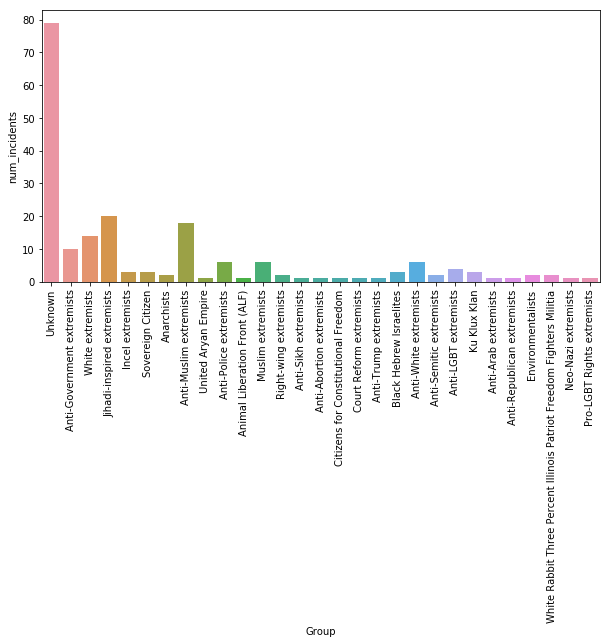

In [268]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x='group_name', y='num_incidents', data=df);
g.set_xlabel('Group');
g.set_xticklabels(rotation=90, labels=list(group_name.keys()));

In [271]:
# total numbers of kills by groups
cursor = db.incidents.aggregate([
    {'$match': {'country_txt': 'United States'}},
    {'$group': {'_id': '$gname', 'total_kill': {'$sum': "$nkill"}}},
    {'$project': {'_id': 0, 'gname': '$_id', 'total_kill': 1}},
    {'$sort': {'total_kill': 1}}
])

In [273]:
i = 0
groups = []
kills = []
for c in cursor:
    groups.append(c['gname'])
    kills.append(c['total_kill'])

In [276]:
# groups and total kill by them
df = pd.DataFrame({'gname': groups, 'total_kill': kills})
df

,gname,total_kill
0,White Rabbit Three Percent Illinois Patriot Fr...,0.0
1,Environmentalists,0.0
2,Ku Klux Klan,0.0
3,Anti-LGBT extremists,0.0
4,Anti-Trump extremists,0.0
5,Anti-Semitic extremists,0.0
6,Citizens for Constitutional Freedom,0.0
7,Black Hebrew Israelites,0.0
8,Right-wing extremists,0.0
9,Animal Liberation Front (ALF),0.0
